In [1]:
# we define the tests parameters - here is the only cell where we need to give our input

input_file_name = "10.json"

split_length = 100
tokenizer_model = None
use_gpu = False

readers = ["FARMReader", "TransformersReader"]

reference_test = ("FARMReader", "deepset/roberta-base-squad2", (10, 3))

models = [
    "deepset/minilm-uncased-squad2",
    #    "deepset/roberta-base-squad2-distilled",
    #    "deepset/roberta-base-squad2",
    #    "deepset/electra-base-squad2",
    #    "deepset/tinyroberta-6l-768d",
    #    "deepset/bert-base-cased-squad2"
    #    ,"distilbert-base-uncased-distilled-squad"
    #    ,"distilbert-base-uncased"
    #    ,"distilbert-base-uncased-finetuned-sst-2-english"
]

scenarios = [
    (10, 3)
    # ,(10,5)
]

In [2]:
import os
import json
import itertools
import matplotlib.pyplot as plt

import pandas as pd
from haystack.nodes import TfidfRetriever
from haystack.document_stores import InMemoryDocumentStore
from haystack.schema import Document
from haystack.nodes import PreProcessor

/home/adi/anaconda3/envs/py382/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - haystack.document_stores.base -  Numba not found, replacing njit() with no-op implementation. Enable it with 'pip install numba'.
INFO - haystack.modeling.model.optimization -  apex not found, won't use it. See https://nvidia.github.io/apex/


In [3]:
tests = list(itertools.product(readers, models, scenarios))

In [4]:
preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=split_length,
    split_respect_sentence_boundary=True,
)

In [5]:
def read_file(path):
    with open(path) as f:
        j = json.load(f)
        return j

In [6]:
def file_to_doc(path, preprocessor):
    data = read_file(path)
    docs = [Document(content=t).to_dict() for t in data["texts"]]

    return preprocessor.process(docs)

In [7]:
def file_to_docstore(name):
    document_store = InMemoryDocumentStore()

    fpath = f"./data/{name}"
    docs = []

    for d in file_to_doc(fpath, preprocessor):

        d["id"] = f"{d['id']}-{d['meta']['_split_id']}"

        docs.append(d)

    print(f"{len(docs)} documents found")
    data = read_file(fpath)

    document_store.write_documents(docs)
    retriever = TfidfRetriever(document_store=document_store)

    return document_store, retriever, data["query"]

In [8]:
def get_scores(prediction):
    scores = ["{:.3f}".format(a.score) for a in prediction["answers"]]
    answers = [a.answer for a in prediction["answers"]]
    df = pd.DataFrame(dict(scores=scores, answers=answers))

    return df

In [9]:
document_store, retriever, query = file_to_docstore(input_file_name)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 421.99docs/s]
INFO - haystack.nodes.retriever.sparse -  Found 34 candidate paragraphs from 34 docs in DB


34 documents found


In [10]:
def get_parameters(test_id):
    # test_id is a tuple with 3 elements:
    # test_id[0] = reader
    # test_id[1] = model
    # topk_retriever = test_id[2][0]
    # topk_reader = test_id[2][1]
    # e.g. ("FARMReader", "deepset/minilm-uncased-squad2", (10,3))

    test_reader = test_id[0]
    model = test_id[1]
    topk_retriever = test_id[2][0]
    topk_reader = test_id[2][1]

    return test_reader, model, topk_retriever, topk_reader

In [11]:
def get_reader(test_id):
    (test_reader, model, topk_retriever, topk_reader) = get_parameters(test_id)

    reader = None

    if test_reader == "FARMReader":
        reader = FARMReader(model_name_or_path=model, use_gpu=use_gpu)

    if test_reader == "TransformersReader":
        reader = TransformersReader(
            model_name_or_path=model,
            tokenizer=tokenizer_model,
            use_gpu=use_gpu,
        )

    return reader

In [12]:
def get_comparison_score_same_length(reference_df, compared_df):

    score = 0

    # create a set out of each data frame elements from the column "answers"

    reference = set(reference_df["answers"])
    compared = set(compared_df["answers"])

    # intersect the two sets and start with a score of 0.5 * cardinal(intersection)
    # then compare the elements position by position and
    # for each coincidence add 0.5 to the prediction_comparison_score

    intersection = reference.intersection(compared)

    score = 0.5 * len(intersection)

    for i in range(len(compared_df)):
        compared_string = str(compared_df["answers"][i])
        reference_string = str(reference_df["answers"][i])

        if compared_string.strip() == reference_string.strip():
            score += 0.5

    return score

In [13]:
def get_comparison_score(reference_df, compared_df):

    score = 0

    reference_elements = reference_df.shape[0]
    compared_elements = compared_df.shape[0]

    if compared_elements != reference_elements:
        min_number_of_df_elements = min(reference_elements, compared_elements)

        adjusted_reference_df = reference_df.head(min_number_of_df_elements)
        adjusted_compared_df = compared_df.head(min_number_of_df_elements)

        score = get_comparison_score_same_length(
            adjusted_reference_df, adjusted_compared_df
        )
    else:
        score = get_comparison_score_same_length(reference_df, compared_df)

    return score

In [14]:
def execute_test(test_id):
    (test_reader, model, topk_retriever, topk_reader) = get_parameters(test_id)

    reader = get_reader(test_id)

    pipe = ExtractiveQAPipeline(reader, retriever)

    prediction = pipe.run(
        query=query,
        params={
            "Retriever": {"top_k": topk_retriever},
            "Reader": {"top_k": topk_reader},
        },
    )
    end = time.time()

    predictions_df = get_scores(prediction)

    del pipe
    pipe = None

    del reader
    reader = None

    return predictions_df

In [15]:
# here we execute all the tests

import time
from haystack.pipelines import ExtractiveQAPipeline
from haystack.nodes import FARMReader, TransformersReader


test_prediction = {}
test_speed = {}

results_df_columns = [
    "speed",
    "accuracy",
    "reader",
    "model",
    "topk_retriever",
    "topk_reader",
]

results_df_rows = []

for test in tests:
    results_df_rows.append(test)

reference_test_start_time = time.time()
reference_answers_df = execute_test(reference_test)
reference_test_end_time = time.time()

reference_test_time = reference_test_end_time - reference_test_start_time

results_df = pd.DataFrame(columns=results_df_columns, index=results_df_rows)

for test in tests:
    if test != reference_test:
        start = time.time()
        test_prediction[test] = execute_test(test)
        end = time.time()

        test_speed[test] = end - start
        results_df.at[test, "speed"] = end - start
    else:
        test_prediction[test] = reference_answers_df
        test_speed[test] = reference_test_time
        results_df.at[test, "speed"] = reference_test_time

    accuracy_score = get_comparison_score(test_prediction[test], reference_answers_df)

    results_df.at[test, "accuracy"] = accuracy_score

    (
        results_df.at[test, "reader"],
        results_df.at[test, "model"],
        results_df.at[test, "topk_retriever"],
        results_df.at[test, "topk_reader"],
    ) = get_parameters(reference_test)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2
INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.infer -  Got ya 11 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0     0     0     0     0     0     0     0     0     0  
INFO - haystack.modeling.infer -  /w\   /w\   /w\   /w\   /w\ 

In [16]:
results_df

,speed,accuracy,reader,model,topk_retriever,topk_reader
"(FARMReader, deepset/minilm-uncased-squad2, (10, 3))",15.159086,1.5,FARMReader,deepset/roberta-base-squad2,10,3
"(TransformersReader, deepset/minilm-uncased-squad2, (10, 3))",12.033616,1.5,FARMReader,deepset/roberta-base-squad2,10,3


Please see below the scatter chart having as points the tests, on X axis the Accuracy and on Y axis the Speed.


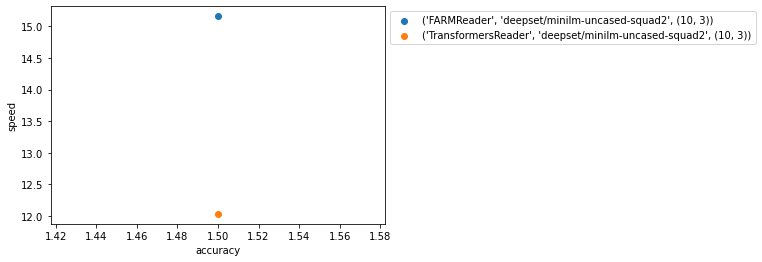

In [17]:
print(
    "Please see below the scatter chart having as points the tests, on X axis the Accuracy and on Y axis the Speed."
)

for ticker, row in results_df.iterrows():
    plt.scatter(row["accuracy"], row["speed"], label=ticker)

plt.xlabel("accuracy")
plt.ylabel("speed")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [18]:
print("For reference, please see below the answers and the speed per each test.\n")

print("The reference test answers: ")
print(reference_answers_df)
print("\n")

for test in tests:
    print("test is: ==> " + str(test) + " <==")
    print("answers are: " + str(test_prediction[test]))
    print("speed is: " + str(test_speed[test]))
    print("\n")


print("\nDone")

del test_prediction
test_prediction = None

del test_speed
test_speed = None

For reference, please see below the answers and the speed per each test.

The reference test answers: 
  scores                                         answers
0  0.452  The Biodiversity Information System for Europe
1  0.380                    corine land cover vegetation
2  0.265                             external contractor


test is: ==> ('FARMReader', 'deepset/minilm-uncased-squad2', (10, 3)) <==
answers are:   scores                                              answers
0  0.733       The Biodiversity Information System for Europe
1  0.579  Personal data collected by the European BISE portal
2  0.528                         corine land cover vegetation
speed is: 15.159085512161255


test is: ==> ('TransformersReader', 'deepset/minilm-uncased-squad2', (10, 3)) <==
answers are:   scores                                         answers
0  0.509  The Biodiversity Information System for Europe
1  0.492                                                
2  0.482                    corine 